# Preprocessing and Training Data

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#load final data from EDA step
eda_df = pd.read_csv('../data/EDA_final_data.csv')

In [4]:
eda_df.head()

,step,type,amount,isFraud,drain_Orig_account
0,1,TRANSFER,181.00,1,1
1,1,CASH_OUT,181.00,1,1
2,1,CASH_OUT,229133.94,0,1
3,1,TRANSFER,215310.30,0,1
4,1,TRANSFER,311685.89,0,1


## Encoding Categorical Variables

The transaction type and whether the originator's account was completely emptied or not are the dataset's only two categorical features. Both are nominal features with low cardinality. Thus, one-hot encoding is a good choice for encoding these two variables.

In [17]:
#Convert drain_Orig_account to categorical feature
eda_df['drain_Orig_account'] = eda_df['drain_Orig_account'].map(lambda x: np.where(x==1,'Yes','No'))

In [18]:
#One-hot encoding categorical features
df_dummies = pd.get_dummies(eda_df)
df_dummies.head()

,step,amount,isFraud,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes
0,1,181.00,1,0,1,0,1
1,1,181.00,1,1,0,0,1
2,1,229133.94,0,1,0,0,1
3,1,215310.30,0,0,1,0,1
4,1,311685.89,0,0,1,0,1


## Scaling Numerical Variables

The transaction amount is the only scalable numerical feature in the dataset. Since the data is highly right-skewed, a power transform scaler would likely be the most appropriate choice. This type of scaler would bring the transaction amount distribution closer to normal.

<AxesSubplot:>

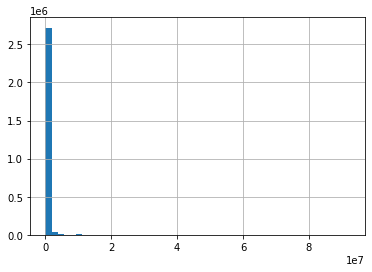

In [25]:
#highly right-skewed distribution 
df_dummies.amount.hist(bins=50)

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'amount_scaled'}>]], dtype=object)

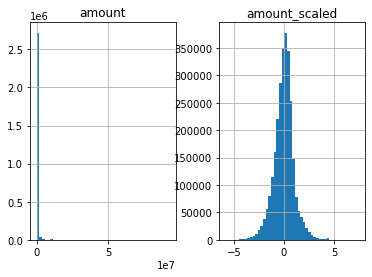

In [19]:
#scaling numerical features
#
# Import PowerTransformer
from sklearn.preprocessing import PowerTransformer
# Instantiate PowerTransformer
pow_trans = PowerTransformer()
# Train the transform on the data
pow_trans.fit(df_dummies[['amount']])
# Apply the power transform to the data
df_dummies['amount_scaled'] = pow_trans.transform(df_dummies[['amount']])
# Plot the data before and after the transformation
df_dummies[['amount', 'amount_scaled']].hist(bins=50)

In [20]:
df_dummies.head()

,step,amount,isFraud,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
0,1,181.00,1,0,1,0,1,-4.096788
1,1,181.00,1,1,0,0,1,-4.096788
2,1,229133.94,0,1,0,0,1,0.287913
3,1,215310.30,0,0,1,0,1,0.234287
4,1,311685.89,0,0,1,0,1,0.558130


## Scaling Step?

Although the variable "step" has shown some relation with the outcome of the transaction (fraud/legitimate), and it could theoretically be scaled. Unfortunately, we don't have any information on day of week or even time of day from the original data set, so no categorical encoding is easy to do. 

Also, there is no clear way to numerically scale the variable that I see.

# Imbalanced Data

The fraud dataset is highly imbalanced. In the above dataframe, there are only 8,213 observations of fraud out of close to 2.8M observations, or approximately 0.3 percent of transactions. This presents a challenge in that a classifier could predict all observations as legitimate and still get 99.7% accuracy! 

Since we're very interested in flagging fraud, we will need to combat the problem of imbalance by resampling. Since we have so many records, under-sampling would be a good approach for our case. That is, we select the same number of legitimate transactions as fradulent.

In [21]:
#Under-sampling legitimate transactions

#get size of group for fraud and under-sampled legitimate transactions
size_of_group = df_dummies.isFraud.sum()
#get all indicies for legitimate and fradulent transactions
legit_indicies = df_dummies[df_dummies.isFraud == 0].index
fraud_indicies = df_dummies[df_dummies.isFraud == 1].index
#get random subset for undersampled legitimate transactions
random_legit_group = np.random.choice(legit_indicies,size_of_group,replace=False)

In [23]:
#balanced dataframe
blanced_df = pd.concat([df_dummies.loc[random_legit_group],df_dummies.loc[fraud_indicies]])

In [24]:
blanced_df

,step,amount,isFraud,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
1874910,307,419858.72,0,1,0,1,0,0.827968
630934,139,645405.46,0,1,0,1,0,1.232127
1535084,259,70870.62,0,1,0,1,0,-0.668246
134527,16,179769.33,0,1,0,1,0,0.080725
431320,44,83710.32,0,1,0,0,1,-0.539433
...,...,...,...,...,...,...,...,...
2770404,743,339682.13,1,1,0,0,1,0.635196
2770405,743,6311409.28,1,0,1,0,1,3.698260
2770406,743,6311409.28,1,1,0,0,1,3.698260
2770407,743,850002.52,1,0,1,0,1,1.500422


# Is undersampled data representative of the entire sample?

Although, we now balanced the label in the dataset, can we be sure that the undersampled subset of legitimate transactions is representative of all records? For instance, the subset could contain only a small percentage of type_CASH_OUT relative to the population, or the amounts could be significantly different. Let's verify that this is not the case.

In [39]:
blanced_df[blanced_df.isFraud==0].groupby('isFraud')['type_CASH_OUT'].value_counts(normalize=True)

isFraud  type_CASH_OUT
0        1                0.808961
         0                0.191039
Name: type_CASH_OUT, dtype: float64

In [40]:
df_dummies[df_dummies.isFraud==0].groupby('isFraud')['type_CASH_OUT'].value_counts(normalize=True)

isFraud  type_CASH_OUT
0        1                0.808554
         0                0.191446
Name: type_CASH_OUT, dtype: float64

In [41]:
blanced_df[blanced_df.isFraud==0].groupby('isFraud')['drain_Orig_account_Yes'].value_counts(normalize=True)

isFraud  drain_Orig_account_Yes
0        0                         0.580056
         1                         0.419944
Name: drain_Orig_account_Yes, dtype: float64

In [42]:
df_dummies[df_dummies.isFraud==0].groupby('isFraud')['drain_Orig_account_Yes'].value_counts(normalize=True)

isFraud  drain_Orig_account_Yes
0        0                         0.572781
         1                         0.427219
Name: drain_Orig_account_Yes, dtype: float64

In [43]:
blanced_df[blanced_df.isFraud==0].groupby('isFraud')['amount_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,8213.0,-0.003493,0.983469,-4.244368,-0.551489,0.045756,0.537324,5.85893


In [44]:
df_dummies[df_dummies.isFraud==0].groupby('isFraud')['amount_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,2762196.0,-0.002808,0.995905,-5.78145,-0.546941,0.038822,0.541705,7.440142


In [46]:
bal_amts = blanced_df[blanced_df.isFraud==0]['amount_scaled']
orig_amts = df_dummies[df_dummies.isFraud==0]['amount_scaled']

(array([1.54159453e-04, 2.90329073e-03, 2.71901131e-02, 1.72593693e-01,
        4.41158627e-01, 9.53337940e-02, 1.41980035e-02, 2.42082367e-03,
        3.49391585e-04, 3.66915928e-05]),
 array([-5.78145006, -4.45929089, -3.13713171, -1.81497254, -0.49281337,
         0.8293458 ,  2.15150497,  3.47366414,  4.79582331,  6.11798248,
         7.44014165]),
 <BarContainer object of 10 artists>)

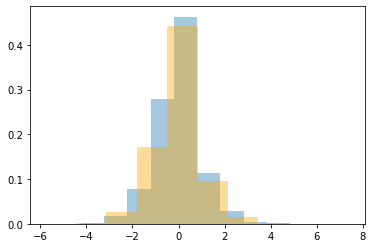

In [50]:
plt.hist(bal_amts,density=True,alpha=0.4)
plt.hist(orig_amts,density=True,alpha=0.4,color='orange')

In [51]:
#Kolmogorov-Smirnov test for equality of distributions of amount_scaled
from scipy.stats import ks_2samp
#evaluate metric for bal_amts and orig_amts
ks_2samp(bal_amts, orig_amts)

KstestResult(statistic=0.007016008644660121, pvalue=0.8122474143726788)

### Conclusion

Comparison of the ratio of transaction types shows no important difference of the undersampled group of legitimate transactions against the entire population. Furthermore, the Kolmogorov-Smirnov indicates no significant difference in the distributions of the scaled amounts between these two groups. Hence, the undersampled subset can be considered statistically representative of the entire population and should pose no issues during training the model.

# Split Data into Train and Test

Final preprocessing step of splitting dataset into training and testing subsets 

In [52]:
#Define train and test sets
X = blanced_df.drop(columns=['isFraud','amount'])
y = blanced_df['isFraud']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
X_train.shape, X_test.shape

((11498, 6), (4928, 6))

In [55]:
y_train.shape, y_test.shape

((11498,), (4928,))

In [56]:
#Inspect final data features format
X_train.head()

,step,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
1058040,202,1,0,1,0,0.579142
848053,169,1,0,0,1,-1.604630
1225072,215,1,0,0,1,0.615045
2666463,526,1,0,0,1,0.215005
2732403,630,0,1,0,1,-1.668755


# Summary and Final Dataset

In this notebook, the two categorical features (transaction type and whether the sender's account was emptied in the transaction) were one-hot encoded. The numerical feature of amount was scaled with a power transformation. Finally, the imbalanced dataset was undersampled for legitimate transactions to give a perfectly balanced final dataset.

In [57]:
#save final training and testing data
X_train.to_csv('../data/Training_Data_Features.csv',index=False,index_label=False)
X_test.to_csv('../data/Testing_Data_Features.csv',index=False,index_label=False)
y_train.to_csv('../data/Training_Data_Labels.csv',index=False,index_label=False)
y_test.to_csv('../data/Testing_Data_Labels.csv',index=False,index_label=False)